In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

In [3]:
file_path_train = "/kaggle/input/titanic/train.csv"
train = pd.read_csv(file_path_train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
file_path_test = "/kaggle/input/titanic/test.csv"
test = pd.read_csv(file_path_test)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# 3.3 Family size
for df in [train, test]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = np.where(df['FamilySize'] == 1, 1, 0)

In [6]:
# print(train[train['Embarked'].isna()])
train.loc[train['PassengerId'].isin([62, 830]), 'Embarked'] = 'C'
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FamilySize       0
IsAlone          0
dtype: int64

In [7]:
mapping = {'S':0, 'C':1, 'Q':2}
for df in [train, test]:
    df['Sex'] = df['Sex'].map({'male':0, 'female':1})
    df['Embarked'] = df['Embarked'].map(mapping)

In [8]:
missing_fare_index = test[test['Fare'].isna()].index
# print(test.loc[missing_fare_index])
for idx in missing_fare_index:
    pclass = test.loc[idx, 'Pclass']
    median_fare = test[test['Pclass'] == pclass]['Fare'].median()
    test.loc[idx, 'Fare'] = median_fare

In [9]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FamilySize       0
IsAlone          0
dtype: int64

In [10]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FamilySize       0
IsAlone          0
dtype: int64

In [11]:
# age_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']

# train_known_age = train[train['Age'].notna()]
# train_missing_age = train[train['Age'].isna()]

# from sklearn.ensemble import RandomForestRegressor

# age_model = RandomForestRegressor(n_estimators=100, random_state=42)
# age_model.fit(train_known_age[age_features], train_known_age['Age'])

# train.loc[train['Age'].isna(), 'Age'] = age_model.predict(train_missing_age[age_features])
# test_missing_age = test[test['Age'].isna()]
# test.loc[test['Age'].isna(), 'Age'] = age_model.predict(test_missing_age[age_features])



In [12]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import randint, uniform

# ✅ 1. Features to use for age prediction
age_features = ['Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']

# ✅ 2. Separate rows with known and missing Age
train_known_age = train[train['Age'].notna()]
test_known_age = test[test['Age'].notna()]
train_missing_age = train[train['Age'].isna()]
test_missing_age = test[test['Age'].isna()]

# ✅ 3. Identify categorical & numerical columns
cat_cols = ['Sex', 'Embarked', 'IsAlone']
num_cols = ['Pclass', 'Fare', 'FamilySize']

# ✅ 4. Preprocessing pipelines
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))  # adds interaction & squared terms
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

# ✅ 5. Regressor model — HistGradientBoosting often performs better than RF
model = HistGradientBoostingRegressor(random_state=42)

# ✅ 6. Build pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# ✅ 7. Hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.2),
    'regressor__max_iter': randint(100, 400),
    'regressor__l2_regularization': uniform(0.0, 0.5)
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    random_state=42,
    verbose=1
)

# ✅ 8. Train on rows with known Age
search.fit(train_known_age[age_features], train_known_age['Age'])
search.fit(test_known_age[age_features], test_known_age['Age'])
best_model = search.best_estimator_
print("Best Params for Age Model:", search.best_params_)

# ✅ 9. Predict missing Age for TRAIN
if not train_missing_age.empty:
    train.loc[train['Age'].isna(), 'Age'] = best_model.predict(train_missing_age[age_features])

# ✅ 10. Predict missing Age for TEST
test_missing_age = test[test['Age'].isna()]
if not test_missing_age.empty:
    test.loc[test['Age'].isna(), 'Age'] = best_model.predict(test_missing_age[age_features])



Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Params for Age Model: {'regressor__l2_regularization': 0.003533152609858703, 'regressor__learning_rate': 0.014612485008283152, 'regressor__max_depth': 5, 'regressor__max_iter': 158}


In [13]:
# import numpy as np
# from sklearn.ensemble import HistGradientBoostingRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint, uniform

# # ✅ 1. Features to use for age prediction (already encoded/scaled)
# age_features = ['Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']

# # ✅ 2. Separate rows with known and missing Age
# train_known_age = train[train['Age'].notna()]
# train_missing_age = train[train['Age'].isna()]
# test_missing_age = test[test['Age'].isna()]

# # ✅ 3. Define model
# model = HistGradientBoostingRegressor(random_state=42)

# # ✅ 4. Hyperparameter search space
# param_dist = {
#     'max_depth': randint(3, 10),
#     'learning_rate': uniform(0.01, 0.2),
#     'max_iter': randint(100, 400),
#     'l2_regularization': uniform(0.0, 0.5)
# }

# # ✅ 5. RandomizedSearchCV
# search = RandomizedSearchCV(
#     model,
#     param_distributions=param_dist,
#     n_iter=30,
#     cv=3,
#     n_jobs=-1,
#     scoring='neg_mean_absolute_error',
#     random_state=42,
#     verbose=1
# )

# # ✅ 6. Train on known Age values
# search.fit(train_known_age[age_features], train_known_age['Age'])

# best_model = search.best_estimator_
# print("Best Params for Age Model:", search.best_params_)
# print("Best CV Score (MAE):", -search.best_score_)

# # ✅ 7. Predict missing Age for TRAIN
# if not train_missing_age.empty:
#     train.loc[train['Age'].isna(), 'Age'] = best_model.predict(train_missing_age[age_features])

# # ✅ 8. Predict missing Age for TEST
# if not test_missing_age.empty:
#     test.loc[test['Age'].isna(), 'Age'] = best_model.predict(test_missing_age[age_features])

# print("✅ All missing Age values have been filled using the optimized model.")


Missing Ages in Train after imputation: 0
Missing Ages in Test after imputation: 0


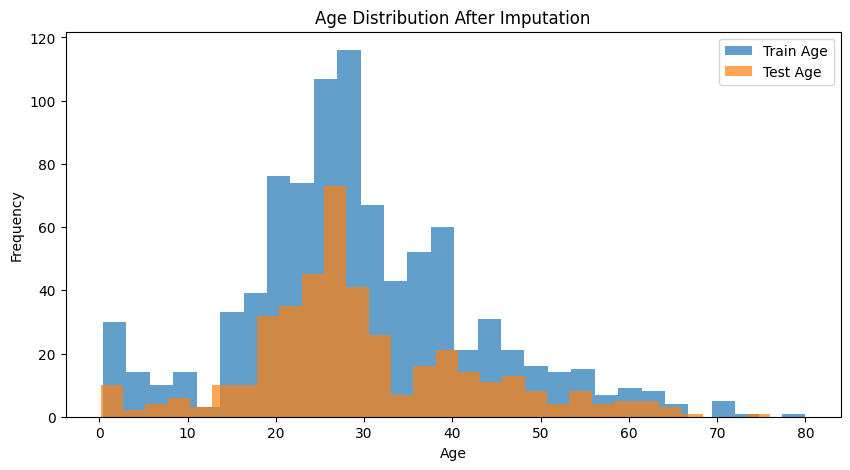

In [14]:
# Check if any missing Age values remain
print("Missing Ages in Train after imputation:", train['Age'].isna().sum())
print("Missing Ages in Test after imputation:", test['Age'].isna().sum())

# Optional: check distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(train['Age'], bins=30, alpha=0.7, label='Train Age')
plt.hist(test['Age'], bins=30, alpha=0.7, label='Test Age')
plt.title('Age Distribution After Imputation')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [15]:
# Extract title
for df in [train, test]:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Map rare titles
title_mapping = {
    'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3,
    'Don':4, 'Rev':4, 'Dr':4, 'Mme':2, 'Ms':1, 'Major':4,
    'Lady':4, 'Sir':4, 'Mlle':1, 'Col':4, 'Capt':4, 'Countess':4, 'Jonkheer':4, 'Dona':4
}

for df in [train, test]:
    df['Title'] = df['Title'].map(title_mapping)

for df in [test,train]:
    print(df.isna().sum())


PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FamilySize       0
IsAlone          0
Title            0
dtype: int64
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FamilySize       0
IsAlone          0
Title            0
dtype: int64


In [16]:
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']

X = train.drop(columns=drop_cols + ['Survived'])
y = train['Survived']
X_test = test.drop(columns=drop_cols)

In [17]:
corr_with_target = train.drop(columns=drop_cols).corr()['Survived'].sort_values(ascending=False)
print(corr_with_target)

Survived      1.000000
Sex           0.543351
Title         0.407753
Fare          0.257307
Embarked      0.111203
Parch         0.081629
FamilySize    0.016639
SibSp        -0.035322
Age          -0.060740
IsAlone      -0.203367
Pclass       -0.338481
Name: Survived, dtype: float64


In [18]:
from sklearn.metrics import accuracy_score 
from xgboost import XGBClassifier 

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [19]:
# xgb_model = XGBClassifier(
#     n_estimators=1000,
#     max_depth=3,
#     learning_rate=0.01,
#     subsample=0.9,
#     colsample_bytree=0.8,
#     gamma=0.1,
#     random_state=42,
#     use_label_encoder=False,
#     eval_metric='logloss'
# )

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
    
xgb_model = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=2,
    subsample=0.9,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy={acc:.4f}")

Validation Accuracy=0.8433


In [20]:
test_predictions = xgb_model.predict(X_test)

# =========================
# Create submission DataFrame
# =========================
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': test_predictions
})

submission.to_csv('titanic_submission.csv', index=False)
print("Submission file created: titanic_submission.csv")

Submission file created: titanic_submission.csv
